## [CoLA](https://pytorch.org/text/stable/datasets.html#cola)

In [1]:
# https://pytorch.org/get-started/previous-versions/

In [2]:
# CUDA 11.8
#conda install pytorch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 pytorch-cuda=11.8 -c pytorch -c nvidia
# CUDA 12.1
!pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1
#conda install pytorch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 cpuonly -c pytorch

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install torchtext

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
from torchtext.datasets import CoLA
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from typing import List, Tuple

/home/ubuntu/.local/lib/python3.10/site-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/ubuntu/.local/lib/python3.10/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/ubuntu/.local/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHT

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [7]:
!pip install torchdata portalocker

Defaulting to user installation because normal site-packages is not writeable


In [8]:
import spacy

spacy.require_gpu()
spacy_en = spacy.load("en_core_web_sm")
spacy_en.disable_pipes(*[pipe for pipe in spacy_en.pipe_names if pipe != "tokenizer"])

import pandas as pd
import torch
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple

def tokenizer(text):
    doc = spacy_en(text)
    tokens = [token.text.lower() for token in doc]
    return tokens
        
def yield_tokens(data_iter):
    for src, label, text in data_iter:
        yield tokenizer(text)

In [9]:
train_iter, dev_iter, test_iter = CoLA(split=('train', 'dev', 'test'))

/home/ubuntu/.local/lib/python3.10/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


In [10]:
for item in train_iter:
    print(item)
    break

('gj04', 1, "One more pseudo generalization and I'm giving up.")


In [11]:
for item in dev_iter:
    print(item)
    break

('gj04', 1, 'The weights made the rope stretch over the pulley.')


In [12]:
for item in test_iter:
    print(item)
    break

('clc95', 1, "They claimed they had settled on something, but it wasn't clear what they had settled on.")


In [13]:
train_iter, dev_iter, test_iter = CoLA(split=('train', 'dev', 'test'))

In [14]:
text_vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
text_vocab.set_default_index(text_vocab["<unk>"])

In [15]:
train_iter, dev_iter, test_iter = CoLA(split=('train', 'dev', 'test'))
labels = [b for a, b, c in list(train_iter)]
labels = set(labels)
labels

{0, 1}

In [16]:
def process_text(text, tokenizer):
    return torch.tensor(text_vocab(tokenizer(text)), dtype=torch.long)

In [17]:
# collate 함수에서 text를 procesor로 tensor 변환
def collate_batch(batch):
    text_list, label_list = [], []
    for src, label, text in batch:
        text_list.append(process_text(text, tokenizer))
        label_list.append(int(label))

    text_list = torch.nn.utils.rnn.pad_sequence(text_list, batch_first=True, padding_value=text_vocab['<pad>'])
    label_list = torch.tensor(label_list, dtype=torch.int64)
    return text_list, label_list

In [18]:
batch_size = 4

train_loader = DataLoader(train_iter, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_iter, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [19]:
#print('훈련 샘플의 개수 : {}'.format(len(train_loader)))
#print('테스트 샘플의 개수 : {}'.format(len(test_loader)))

In [20]:
for text, label in train_loader:
    print(text, label)
    break

tensor([[  84,   30, 3261, 2973,   12,    5,  148, 1560,   55,    1,    0],
        [  84,   30, 3261, 2973,  139,    5,  148, 1560,   55,    1,    0],
        [   2,   30,   33,  467, 5319,    9,    2, 1329,   35,  220,    1],
        [ 411,   41,  411,    2, 4139,   52,  922, 4620,    1,    0,    0]]) tensor([1, 1, 1, 1])


In [21]:
print(text.shape, label.shape)

torch.Size([4, 11]) torch.Size([4])


In [22]:
embed_dim = 256
n_layers = 3
n_vocab = len(text_vocab.get_stoi())

hidden_size = 256
output_size = len(labels)

In [23]:
class CoLAModel(nn.Module):
    def __init__(self, embed_dim, hidden_size, output_size, n_layers, device):
        super(CoLAModel, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.device = device

        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.rnn = nn.GRU(input_size=embed_dim, hidden_size=hidden_size, num_layers=n_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size)
        )        
    def forward(self, x):
        batch_size = x.shape[0]
        hidden = torch.zeros(n_layers, batch_size, self.hidden_size).to(device)  
        x = self.embed(x)
        x, hidden = self.rnn(x, hidden)
        x = x[:,-1,:]
        output = self.fc(x)
        return output

In [24]:
import numpy as np

model = CoLAModel(embed_dim, hidden_size, output_size, n_layers, device).to(device)
X = torch.LongTensor(text).to(device)
with torch.no_grad():
    y_pred = model(X)
    print(y_pred)
    print(np.argmax(y_pred.cpu(), axis=1), label)

tensor([[-0.0104, -0.0173],
        [-0.0191, -0.0233],
        [-0.0396,  0.0879],
        [-0.0081, -0.0330]], device='cuda:0')
tensor([0, 0, 1, 0]) tensor([1, 1, 1, 1])


In [25]:
batch_size = 200
model = CoLAModel(embed_dim, hidden_size, output_size, n_layers, device).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)

n_epochs = 10 # 10회 학습

list_training_loss = []
list_test_loss = []


for epoch in range(n_epochs):
    n_train = 0
    train_loss = 0

    train_loader = DataLoader(train_iter, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
    test_loader = DataLoader(test_iter, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

    model.train()
    for text, label in train_loader:
        X_train = torch.LongTensor(text).to(device)
        y_train = torch.LongTensor(label).to(device)
        y = model(X_train)
        del X_train
        loss = criterion(y, y_train).sum()
        train_loss += loss.data.cpu().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        n_train += len(y_train)
        del y_train

#    if (epoch + 1) % 10 == 0:
    if True:
        model.eval()
        n_test = 0
        test_loss = 0
        correct = 0
        total = 0
        
        for text, label in test_loader:
            X_test = torch.LongTensor(text).to(device)
            y_test = torch.LongTensor(label).to(device)
            y_pred = model(X_test)
            idx_pred = torch.max(y_pred, 1)[1]
            del X_test
            loss = criterion(y_pred, y_test).sum()
            test_loss += loss.data.cpu().numpy()
            n_test += len(y_test)
            correct += (idx_pred == y_test).sum()
            del y_test

        accuracy = correct * 100 / n_test
        print('epoch {}th training loss: {} test loss: {}, accuracy: {}'.format(
                epoch + 1, train_loss / n_train, test_loss / n_test,
                accuracy
            ))
        list_training_loss.append(train_loss / n_train)
        list_test_loss.append(test_loss / n_test)

/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


epoch 1th training loss: 0.0031117858001363206 test loss: 0.003576934800564664, accuracy: 68.54369354248047
epoch 2th training loss: 0.003057848330129657 test loss: 0.003597175149084295, accuracy: 68.54369354248047
epoch 3th training loss: 0.0030359068146923133 test loss: 0.0036559790083505574, accuracy: 67.1844711303711
epoch 4th training loss: 0.002946886204139531 test loss: 0.0036702248656633987, accuracy: 67.3786392211914
epoch 5th training loss: 0.0027201417872780246 test loss: 0.003812407752842579, accuracy: 67.3786392211914
epoch 6th training loss: 0.002310156726349167 test loss: 0.004325374353279188, accuracy: 62.91262435913086
epoch 7th training loss: 0.0019339142138497872 test loss: 0.00512536590539136, accuracy: 61.74757385253906
epoch 8th training loss: 0.0017364694761951068 test loss: 0.004672529280764386, accuracy: 65.04854583740234
epoch 9th training loss: 0.0014965158404662594 test loss: 0.005940931746103231, accuracy: 66.7961196899414
epoch 10th training loss: 0.001356

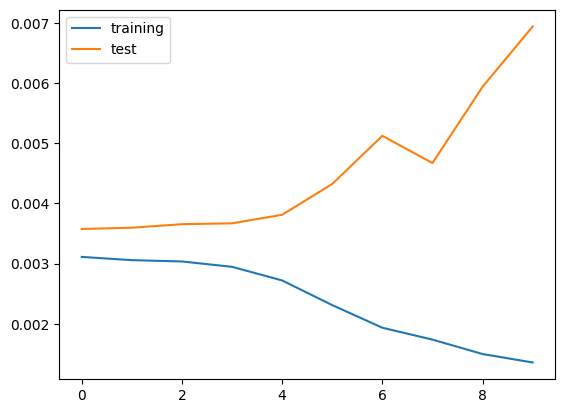

In [26]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.legend()
plt.show()